In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ETL Quind") \
    .getOrCreate()

In [52]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, TimestampType
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ETL:
    def __init__(self, spark, archivo):
        self.spark = spark
        self.archivo = archivo
        logger.info("Inicio de la aplicacion ETL")

    def extraer(self):
        logger.info("Iniciando la extraccion de datos")

        tablas = ["film", "inventory", "rental", "customer", "store"]
        dataframes = {}
        for tabla in tablas:
            df_pandas = pd.read_excel(self.archivo, sheet_name=tabla)
            df_pandas.columns = [col.strip() for col in df_pandas.columns]
            df_spark = self.spark.createDataFrame(df_pandas)
            dataframes[tabla] = df_spark
        return dataframes

    def transformar(self, dataframes):
        columnas_problemas = {
            "film": ["release_year", "rental_rate", "length", "replacement_cost", "num_voted_users", "last_update"],
            "inventory": ["store_id", "last_update"],
            "rental": ["rental_date", "return_date"],
            "customer": ["create_date", "last_update"],
            "store": ["last_update"]
        }

        for nombre_tabla, df in dataframes.items():
            print(f"Transformando tabla: {nombre_tabla}")
            columnas_a_limpiar = columnas_problemas.get(nombre_tabla, [])

            # Limpiar columnas numericas
            for column in columnas_a_limpiar:
                if column not in ["rental_date", "return_date", "last_update", "create_date"]:
                    df = df.withColumn(column, F.regexp_replace(F.col(column), r'[^0-9\.-]+', '').cast("double"))

            # Transformar columnas de fecha y hora
            if "rental_date" in columnas_a_limpiar:
                df = df.withColumn("rental_time", F.date_format(F.to_timestamp(F.col("rental_date")), "HH:mm:ss"))
                df = df.withColumn("rental_date", F.to_date(F.col("rental_date")))

            if "return_date" in columnas_a_limpiar:
                df = df.withColumn("return_time", F.date_format(F.to_timestamp(F.col("return_date")), "HH:mm:ss"))
                df = df.withColumn("return_date", F.to_date(F.col("return_date")))


            if "last_update" in columnas_a_limpiar:
                df = df.withColumn("last_update_time", F.date_format(F.to_timestamp(F.col("last_update")), "HH:mm:ss"))
                df = df.withColumn("last_update_date", F.to_date(F.col("last_update")))


            if "create_date" in columnas_a_limpiar:
                df = df.withColumn("create_time", F.date_format(F.to_timestamp(F.col("create_date")), "HH:mm:ss"))
                df = df.withColumn("create_date", F.to_date(F.col("create_date")))

            # Eliminar filas con valores null
            df = df.dropna(how='any', subset=df.columns)

            dataframes[nombre_tabla] = df

        return dataframes


    def cargar(self ,df, nombre_archivo):

        # Convertir el DataFrame de PySpark a Pandas
        pandas_df = df.toPandas()

        # Guardar el DataFrame de Pandas en un archivo de Excel
        with pd.ExcelWriter(nombre_archivo, engine='xlsxwriter') as writer:
            pandas_df.to_excel(writer, index=False)
        print(f"Archivo '{nombre_archivo}' exportado exitosamente.")




In [54]:
if __name__ == "__main__":
    archivo = "/content/drive/MyDrive/Quind /Films_2.xlsx"
    etl = ETL(spark, archivo)
    extraer_data = etl.extraer()
    transformed_data = etl.transformar(extraer_data)

Transformando tabla: film
Transformando tabla: inventory
Transformando tabla: rental
Transformando tabla: customer
Transformando tabla: store


In [7]:
df_film = transformed_data['film']

In [12]:
df_inventory = transformed_data['inventory']

In [9]:
df_rental = transformed_data['rental']

In [10]:
df_customer = transformed_data['customer']

In [11]:
df_store = transformed_data['store']

In [16]:
#Cantidad de renta por film
rental_film_join = df_rental.join(df_inventory, 'inventory_id').join(df_film, 'film_id')
#rental_film_join.show()
peliculas_mas_renta = rental_film_join.groupBy("title").agg(F.count("rental_id").alias("Conteo_Renta")).orderBy(F.desc("Conteo_Renta"))
peliculas_mas_renta.show(5)

+--------------------+------------+
|               title|Conteo_Renta|
+--------------------+------------+
| FLAMINGOS CONNEC...|          92|
|  BUCKET BROTHERHOOD|          34|
|    ROCKETEER MOTHER|          33|
|       SCALAWAG DUCK|          32|
|      FORWARD TEMPLE|          32|
+--------------------+------------+
only showing top 5 rows



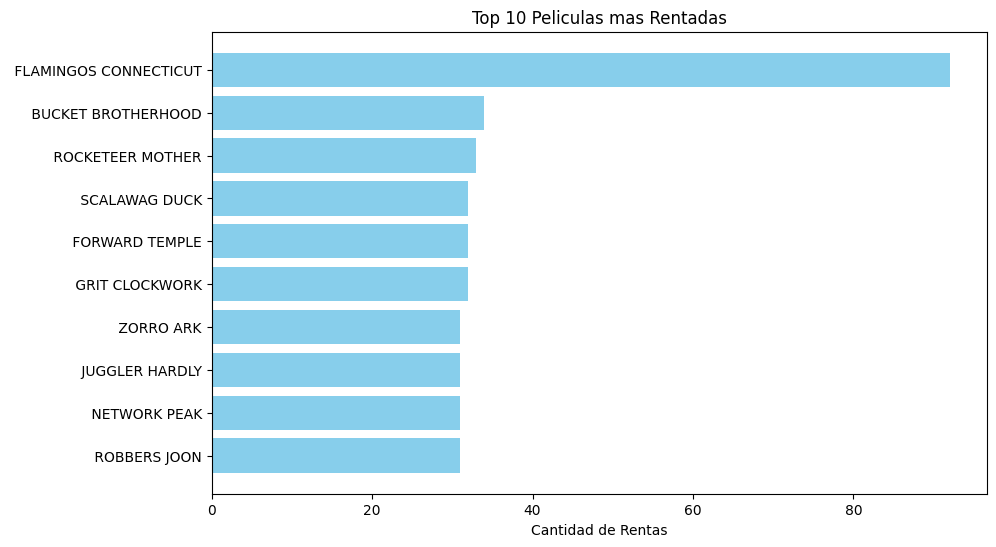

In [19]:
import matplotlib.pyplot as plt
#Grafico para visualizar el analisis anterior
peliculas_mas_renta_pd = peliculas_mas_renta.limit(10).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(peliculas_mas_renta_pd['title'], peliculas_mas_renta_pd['Conteo_Renta'], color='skyblue')
plt.xlabel('Cantidad de Rentas')
plt.title('Top 10 Peliculas mas Rentadas')
plt.gca().invert_yaxis()
plt.show()

In [20]:
#Cantidad de renta por cliente
rental_customer_join = df_rental.join(df_customer, 'customer_id')
cliente_mas_renta = rental_customer_join.groupBy("first_name", "last_name").agg(F.count("rental_id").alias("Conteo_Renta")).orderBy(F.desc("Conteo_Renta"))
cliente_mas_renta.show()

+----------+------------+------------+
|first_name|   last_name|Conteo_Renta|
+----------+------------+------------+
|   ELEANOR|        HUNT|          46|
|      KARL|        SEAL|          45|
|     CLARA|        SHAW|          42|
|    MARCIA|        DEAN|          41|
|    WESLEY|        BULL|          40|
|       SUE|      PETERS|          40|
|       TIM|        CARY|          39|
|    RHONDA|     KENNEDY|          39|
|    MARION|      SNYDER|          38|
|     TAMMY|     SANDERS|          38|
|     TOMMY|     COLLAZO|          38|
|    CURTIS|        IRBY|          37|
|     ELSIE|      KELLEY|          37|
| ELIZABETH|       BROWN|          37|
|      JUNE|     CARROLL|          37|
|     DAISY|       BATES|          37|
|    MARSHA|     DOUGLAS|          37|
|   BRANDON|        HUEY|          36|
|   RUSSELL|     BRINSON|          36|
|     ROGER| QUINTANILLA|          36|
+----------+------------+------------+
only showing top 20 rows



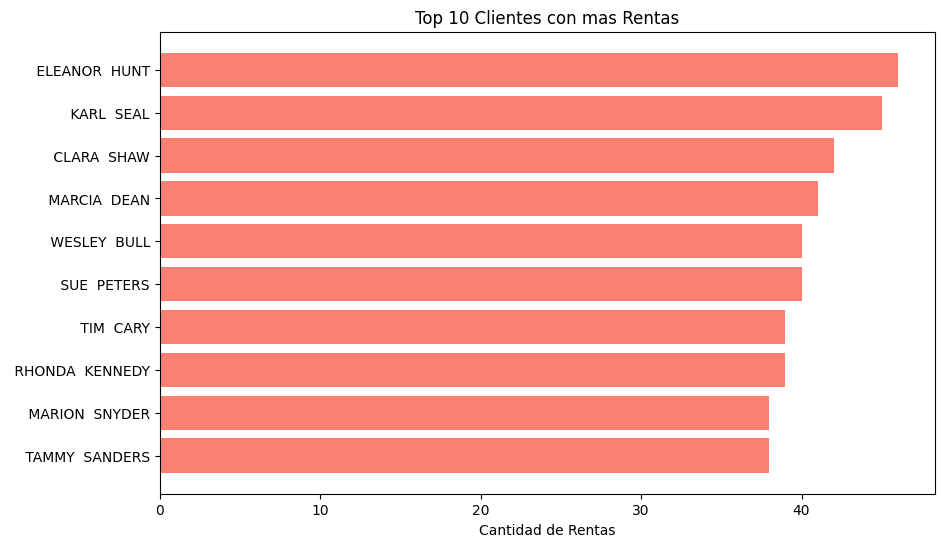

In [22]:
cliente_mas_renta_pd = cliente_mas_renta.limit(10).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(cliente_mas_renta_pd['first_name'] + " " + cliente_mas_renta_pd['last_name'], cliente_mas_renta_pd['Conteo_Renta'], color='salmon')
plt.xlabel('Cantidad de Rentas')
plt.title('Top 10 Clientes con mas Rentas')
plt.gca().invert_yaxis()
plt.show()

In [26]:
# promedio de renta por película
rental_promedio_duracion = rental_film_join.withColumn("rental_duration", F.datediff("return_date", "rental_date"))
rental_promedio_duracion = rental_promedio_duracion.groupBy("title").agg(F.avg("rental_duration").alias("promedio_rental_duration")).orderBy(F.desc("promedio_rental_duration"))
rental_promedio_duracion.show(5)

+---------------+------------------------+
|          title|promedio_rental_duration|
+---------------+------------------------+
|    AFRICAN EGG|       7.090909090909091|
|    FLIGHT LIES|       7.083333333333333|
| HARDLY ROBBERS|                     7.0|
| IMPACT ALADDIN|                     7.0|
|     WAGON JAWS|                     6.9|
+---------------+------------------------+
only showing top 5 rows



In [27]:
#Ingreso total por film
ingreso_por_film = rental_film_join.groupBy("title").agg(F.sum("rental_rate").alias("total_revenue")).orderBy(F.desc("total_revenue"))
ingreso_por_film.show(5)

+--------------------+------------------+
|               title|     total_revenue|
+--------------------+------------------+
| FLAMINGOS CONNEC...|459.08000000000055|
|  BUCKET BROTHERHOOD|169.66000000000003|
|       SCALAWAG DUCK|            159.68|
|   GOODFELLAS SALUTE|            154.69|
|           ZORRO ARK|            154.69|
+--------------------+------------------+
only showing top 5 rows



In [30]:
#Conteo de renta por mes
rental_por_mes = df_rental.withColumn("rental_month", F.month("rental_date"))
rental_por_mes_count = rental_por_mes.groupBy("rental_month").agg(F.count("rental_id").alias("conteo_renta_por_mes")).orderBy("rental_month")
rental_por_mes_count.show()

+------------+--------------------+
|rental_month|conteo_renta_por_mes|
+------------+--------------------+
|           5|                1156|
|           6|                2311|
|           7|                6709|
|           8|                5685|
+------------+--------------------+



In [57]:
#Cargar de datos en archivo Excel (.xlsx)

etl.cargar(rental_promedio_duracion, "promedio_duracion_rental.xlsx")


Archivo 'promedio_duracion_rental.xlsx' exportado exitosamente.
